In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sc_stats

# Text analysis
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.snowball import SpanishStemmer
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('tokenizers/punkt/spanish.pickle')
nltk.download('stopwords')

import unicodedata

from wordcloud import WordCloud, STOPWORDS

import analysis_utils as aute

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\demos\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Error loading tokenizers/punkt/spanish.pickle: Package
[nltk_data]     'tokenizers/punkt/spanish.pickle' not found in index
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\demos\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
tokenize_spanish = nltk.data.load('tokenizers/punkt/spanish.pickle')
spanish_stemmer = SpanishStemmer()
spanish_stopwords_th = stopwords.words('spanish')

In [3]:
def strip_accents(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

In [4]:
all_df_list = []
for conv in os.listdir("Conversations/"):
    excel_name = [file for file in os.listdir("Conversations/" + conv) if ".xlsx" in file][0]
    df_x = pd.read_excel("Conversations/" + conv + "/" + excel_name)
    if df_x.shape[0] > 2:
        all_df_list.append(df_x)
            
print("Number of conversations:", len(all_df_list))

Number of conversations: 2


In [5]:
def clean_text(text, subject_name, 
               tokenize_spanish=tokenize_spanish, 
               spanish_stopwords_th=spanish_stopwords_th, 
               spanish_stemmer=spanish_stemmer):
    
    text = text.lower()
    text = text.replace('?', "").replace('¿', "").replace('!', "").replace('¡', "")
    text = text.replace(subject_name, "")
    text = strip_accents(text)
    
    text_token_list = []
    for word in text.split():
        token_text = tokenize_spanish.tokenize(word)
        if len(token_text) > 0 and word not in spanish_stopwords_th:
            text_token_list.append(spanish_stemmer.stem(token_text[0]))
            
    text = " ".join(text_token_list)
    
    return text

In [6]:
save_res_list = []
for i_df_x, df_x in enumerate(all_df_list):
    
    subject_name = df_x["SubjectId"].iloc[0]
    
    # ###############
    # ### General ###
    # ###############
    num_conv = df_x.shape[0] // 2
    
    text = ". ".join(df_x["SpanishMessage"].values)
    whole_text = clean_text(text, subject_name)
    
    num_words = len(whole_text.split(" "))
    conv_time_s = df_x["UnixTimestampInit"].values[-1] - df_x["UnixTimestampEnd"].values[0]
    # freq_conv_s = np.mean(df_x["unixtimestamp"].values[1:] - df_x["unixtimestamp"].values[:-1])
    
    time_answer_list, time_bot_answer_list, time_pers_answer_list = [], [], []
    for i in range(df_x.shape[0]-1):
        if df_x["Source"].iloc[i] == "Person":
            delta_t = df_x["UnixTimestampInit"].iloc[i+1] - df_x["UnixTimestampEnd"].iloc[i]
            time_bot_answer_list.append(delta_t)
        else:
            delta_t = df_x["UnixTimestampInit"].iloc[i+1] - df_x["UnixTimestampEnd"].iloc[i]
            time_pers_answer_list.append(delta_t)

        delta_t = df_x["UnixTimestampInit"].iloc[i+1] - df_x["UnixTimestampEnd"].iloc[i]
        time_answer_list.append(delta_t)
    
    # ###########
    # ### Bot ###
    # ###########
    df_bot = df_x[df_x["Source"] == "Bot"]
    
    text = ". ".join(df_bot["SpanishMessage"].values)
    bot_text = clean_text(text, subject_name)

    num_words_bot = len(bot_text.split(" "))
    
    # ##############
    # ### Person ###
    # ##############
    df_person = df_x[df_x["Source"] == "Person"]
    
    text = ". ".join(df_person["SpanishMessage"].values)
    person_text = clean_text(text, subject_name)
    
    num_words_person = len(person_text.split(" "))
    
    save_res_list.append({
        # General
        "SubjectId": df_x["SubjectId"].iloc[0],
        "FirstDate": df_x["UnixTimestampInit"].iloc[0],
        "LastDate": df_x["UnixTimestampEnd"].iloc[-1],
        "ConvTime_s": conv_time_s,
        # "FreqTime_s": freq_conv_s,
        "NumConv": num_conv,
        "NumSamples": df_x.shape[0],
        "AllText": whole_text,
        "Numwords": num_words,
        "TimeAnsAll": np.mean(time_answer_list),
        # ### Bot ###
        "BotText": bot_text,
        "NumWordsBot": num_words_bot,
        "TimeAnsBot": np.mean(time_bot_answer_list),
        # ### Person ###
        "PersonText": person_text,
        "NumWordsPerson": num_words_person,
        "TimeAnsPerson": np.mean(time_pers_answer_list),
    })
    
df_save = pd.DataFrame(save_res_list)
df_save.head(5)

,SubjectId,FirstDate,LastDate,ConvTime_s,NumConv,NumSamples,AllText,Numwords,TimeAnsAll,BotText,NumWordsBot,TimeAnsBot,PersonText,NumWordsPerson,TimeAnsPerson
0,jose1,1.655144e+09,1.655144e+09,215.447323,12,24,llamas. nombr sus gradu universidad. buen trab...,119,2.958246,nombr sus gradu universidad. buen trabajo.. ho...,68,0.254713,"llamas. hol susan, tal . alegr susan. dedic . ...",50,5.907556
1,joseid2,1.655329e+09,1.655330e+09,391.241065,21,42,llamas. nombr sus gradu universidad. buen trab...,233,3.032560,nombr sus gradu universidad. buen trabajo.. en...,140,0.294739,llamas. genial alegr mucho. llam jose. tambi l...,93,5.907272


Correlation value 1.0
P-value -
Coefficients: 
 [12.66666667] 
Intercept: 
 -33.0
R-square: 1.00


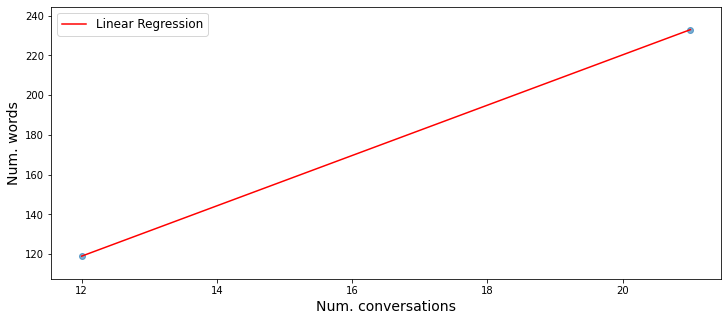

Correlation value 1.0
P-value -
Coefficients: 
 [0.64848725] 
Intercept: 
 -20.714841380711505
R-square: 1.00


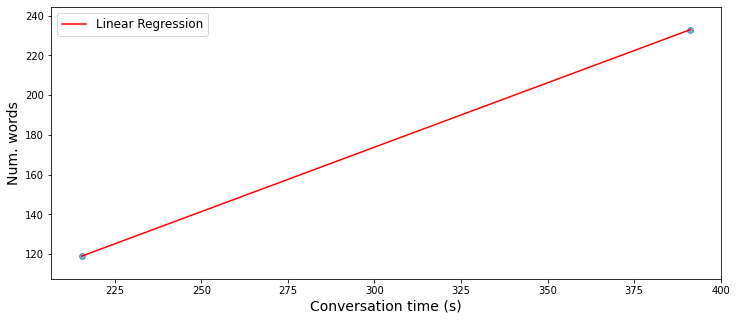

In [7]:
aute.make_scatter_plot(df=df_save, 
                       x_feat="NumConv", x_name="Num. conversations", 
                       y_feat="Numwords", y_name="Num. words", 
                       lr_mode=True)

aute.make_scatter_plot(df=df_save, 
                       x_feat="ConvTime_s", x_name="Conversation time (s)", 
                       y_feat="Numwords", y_name="Num. words", 
                       lr_mode=True)

P-value 0.5193879760606462 string p value -


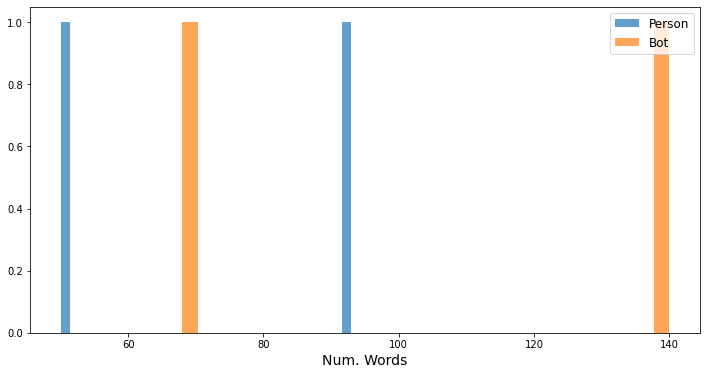


Mean answer time (s) 2.9954 +/- 0.03716
Mean answer time person (s) 5.90741 +/- 0.00014
Mean answer time bot (s) 0.27473 +/- 0.02001

P-value 1.2623993361140451e-05 string p value ***


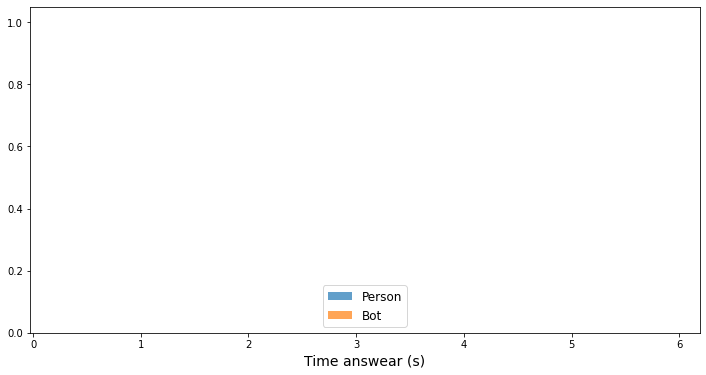

In [20]:
_, p = sc_stats.f_oneway(df_save["NumWordsPerson"].values, df_save["NumWordsBot"].values)
print("P-value", p, "string p value", aute.get_p_string(p))

plt.figure(figsize=(12, 6))

plt.hist(df_save["NumWordsPerson"].values, bins=31, alpha=0.7, label="Person")
plt.hist(df_save["NumWordsBot"].values, bins=31, alpha=0.7, label="Bot")
plt.xlabel("Num. Words", fontsize=14)
plt.legend(fontsize=12)

plt.show()

print()
print("Mean answer time (s)", np.round(np.mean(df_save["TimeAnsAll"].values),5), 
      "+/-", np.round(np.std(df_save["TimeAnsAll"].values),5) )
print("Mean answer time person (s)", np.round(np.mean(df_save["TimeAnsPerson"].values),5), 
      "+/-", np.round(np.std(df_save["TimeAnsPerson"].values),5) )
print("Mean answer time bot (s)", np.round(np.mean(df_save["TimeAnsBot"].values),5), 
      "+/-", np.round(np.std(df_save["TimeAnsBot"].values),5) )
print()
_, p = sc_stats.f_oneway(df_save["TimeAnsPerson"].values, df_save["TimeAnsBot"].values)
print("P-value", p, "string p value", aute.get_p_string(p))

plt.figure(figsize=(12, 6))

plt.hist(df_save["TimeAnsPerson"].values, bins=31, alpha=0.7, label="Person")
plt.hist(df_save["TimeAnsBot"].values, bins=31, alpha=0.7, label="Bot")
plt.xlabel("Time answear (s)", fontsize=14)
plt.legend(fontsize=12)

plt.show()

## WordCloud analysis

- Falta tokenizar las palabras, eliminar acentos y etc.

- Estaria bien establecer un protocolo para eliminar el nombre del sujeto.

- Estudiar el número y cuales son las stopwords localizadas en el Bot y en la persona. Ver si estas stopwords son las mismas para ambos o distintas, etc. Posiblemente el sujeto utilice más stopwords que el sujeto o quizá no. 

### Whole text

In [9]:
whole_text = " ".join(df_save["AllText"]).replace(".", " ").replace(",", " ").lower()

all_words_list = [word for word in whole_text.split() if word not in spanish_stopwords_th]
uniq_words_list = list(set(all_words_list))
freq_words_appear = [
    {"Word": word, "Times": np.sum(np.array(all_words_list)==word)} for word in uniq_words_list
]
df_freq_all_words = pd.DataFrame(freq_words_appear).sort_values("Times", ascending=False).reset_index(drop=True)
df_freq_all_words.head(15)

,Word,Times
0,gust,10
1,buen,9
2,jose,6
3,si,6
4,alegr,6
5,pelicul,6
6,trabaj,5
7,fisic,5
8,llam,5
9,pues,5


In [10]:
print("Number of different words", df_freq_all_words.shape[0])
print("Mean frequency", np.round(np.mean(df_freq_all_words["Times"]), 5), 
      "+/-", np.round(np.std(df_freq_all_words["Times"]), 5), 
      "Max", np.max(df_freq_all_words["Times"]), 
      "Min", np.min(df_freq_all_words["Times"]) )

Number of different words 189
Mean frequency 1.66138 +/- 1.39221 Max 10 Min 1


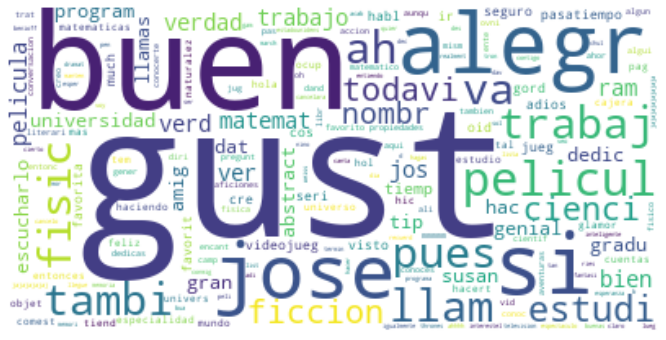

In [11]:
plt.figure(figsize=(15, 6))

all_wordcloud = WordCloud(collocations = False, background_color = 'white').generate(" ".join(all_words_list))

plt.imshow(all_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Bot analysis

In [12]:
whole_bot_text = " ".join(df_save["BotText"]).replace(".", " ").replace(",", " ").lower()

all_bot_words_list = [word for word in whole_bot_text.split() if word not in spanish_stopwords_th]
uniq_bot_words_list = list(set(all_bot_words_list))
freq_bot_words_appear = [
    {"Word": word, "Times": np.sum(np.array(all_bot_words_list)==word)} for word in uniq_bot_words_list
]
df_freq_bot_words = pd.DataFrame(freq_bot_words_appear).sort_values("Times", ascending=False).reset_index(drop=True)
df_freq_bot_words.head(15)

,Word,Times
0,jose,5
1,gust,5
2,todavi,4
3,trabaj,4
4,pelicul,4
5,ah,4
6,buen,4
7,nombr,3
8,trabajo,3
9,vas,3


In [13]:
print("Number of different words", df_freq_bot_words.shape[0])
print("Mean frequency", np.round(np.mean(df_freq_bot_words["Times"]), 5), 
      "+/-", np.round(np.std(df_freq_bot_words["Times"]), 5), 
      "Max", np.max(df_freq_bot_words["Times"]), 
      "Min", np.min(df_freq_bot_words["Times"]) )

Number of different words 145
Mean frequency 1.37931 +/- 0.82269 Max 5 Min 1


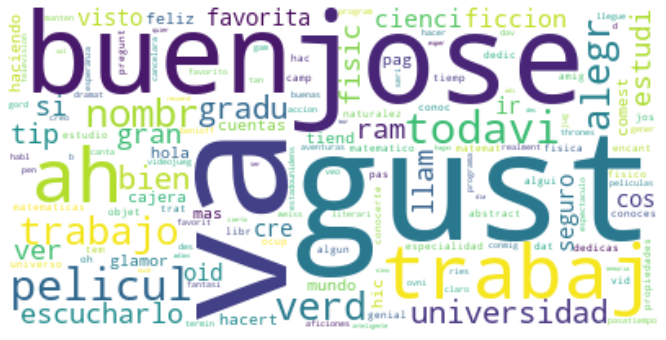

In [14]:
plt.figure(figsize=(15, 6))

all_wordcloud = WordCloud(collocations = False, background_color = 'white').generate(" ".join(all_bot_words_list))

plt.imshow(all_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Classifier

- Hacer un clasificador que sepa o pueda descubrir por las métricas obtenidas de la conversación si es un Bot o una persona. Lo interesante sería que NO.